<a href="https://colab.research.google.com/github/gabbypaola/DATA604/blob/main/G_Martinez_Final_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CUNY DATA604 Final Project**

Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a [PowerPoint presentation](https://docs.google.com/presentation/d/1Bmvpi8jSve6e-MD2xjKpfrnfl5kMvloduunF6GjsG7w/edit?usp=sharing) to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!

In [1]:
# Check if the libraries we need are installed, load libraries
try:
    import simpy
except ImportError:
    !pip install simpy
    import simpy

try:
    import pint
except ImportError:
    !pip install pint
    import pint

try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

     |████████████████████████████████| 215kB 8.2MB/s 
  Created wheel for modsimpy: filename=modsimpy-1.1.3-cp37-none-any.whl size=20356 sha256=97b03fbb69d12a0bc404d5716ec1aac3690f6506beaaa333a448211aa22e4a4a
  Stored in directory: /root/.cache/pip/wheels/59/34/ac/e82f103fbfb5d961b1a4d2b8e89bb6629a4c0b242e5373cbfa
Successfully built modsimpy


In [2]:
import random
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

%load_ext google.colab.data_table
from google.colab import data_table

In [3]:
#Initialize variables
time_in_line = []
transaction_time = []
wait_times = []

#Initialize global variables
record = pd.DataFrame() 
trans_start_time = []

In [4]:
class Bank(object):
    def __init__(self, env, num_teller, num_lobby_leader):
        self.env = env
        self.lobby_leader = simpy.Resource(env, num_lobby_leader)
        self.teller = simpy.Resource(env, num_teller)
    # lobby leader greets, preps, and properly routes clients upon arrival   
    def lobby_leader_service(self, client): 
        yield self.env.timeout(random.randint(1, 4))

    def prepared_client_teller_service(self, client):
        yield self.env.timeout(random.randint(1, 10))

    def unprepared_client_teller_service(self, client):
        yield self.env.timeout(random.randint(4, 15))

    def client_exit_reroute(self, client):
        yield self.env.timeout(0)


In [5]:
def go_to_bank(env, client, bank):
    """
    Simulates client - associate interaction upon entering the bank.

    Depending on the day of the week and time of the month, 
    lobby_leader_interation % coverage will vary in real life
    """  

    global record
    global trans_start_time

    lobby_leader_interaction = np.random.choice(['True', 'False'], p=[0.75, 0.25]) # lobby leader % coverage 
    lobby_leader_True = np.random.choice(['Prepared', 'Unprepared', 'Exit or Reroute'], p=[0.65, 0.15, 0.20])
    lobby_leader_False = np.random.choice(['Prepared', 'Unprepared'], p=[0.30, 0.70])

    # Client arrives at the bank
    arrival_time = env.now

    if lobby_leader_interaction == 'True':
          with bank.lobby_leader.request() as request:
            yield request
            yield env.process(bank.lobby_leader_service(client)) #LL interaction

            get_in_line_time = env.now #gets in line

          with bank.teller.request() as request:
              yield request #client waits for teller
              trans_start_time = env.now 
         
          if lobby_leader_True == 'Prepared':
              # less time spent
              yield env.process(bank.prepared_client_teller_service(client))

          elif lobby_leader_True == 'Unprepared':
              # more time spent
                yield env.process(bank.unprepared_client_teller_service(client))
        
          else:
              # lobby_leader_True == 'Exit or Reroute'
              yield env.process(bank.client_exit_reroute(client))
   
    else: 
          # lobby_leader_interaction == 'False':
          get_in_line_time = arrival_time  #automatically gets in line w/out LL interaction

          with bank.teller.request() as request:
            yield request #client waits for teller
            trans_start_time = env.now 

          if lobby_leader_False == 'Prepared':
              # less time spent
              yield env.process(bank.prepared_client_teller_service(client))

          else:
            # more time spent
              yield env.process(bank.unprepared_client_teller_service(client))

    # Client exits the bank
    end_time = env.now

    # Values for functions
    wait_times.append(end_time - arrival_time)
    time_in_line.append(trans_start_time - get_in_line_time)
    transaction_time.append(end_time-trans_start_time)

    # Values for Dataframe
    total_time = (end_time - arrival_time)
    time_on_line = (trans_start_time - get_in_line_time)
    trans_time = (end_time-trans_start_time)
    
    # Dataframe set up
    row = pd.DataFrame([['Client_{}'.format(client), lobby_leader_interaction, arrival_time, get_in_line_time, trans_start_time, end_time, time_on_line, trans_time, total_time]],
                          columns = ['Client ID', 'Lobby Leader Interaction', 'Bank Arrival Time', 'Enter Line', 'Start Transaction', 'Bank Exit Time', 'Total Time in Line','Total Transaction Time','Total Visit Time']) 
    record = record.append(row, ignore_index = True)

    return arrival_time, end_time, time_in_line, wait_times


In [6]:
def calculate_time_in_line(time_in_line):
    average_wait_in_line = statistics.mean(time_in_line)
    # Pretty print the results
    minutes_in_line, frac_minutes = divmod(average_wait_in_line, 1)
    seconds_in_line = frac_minutes * 60
    return round(minutes_in_line), round(seconds_in_line)

In [7]:
def calculate_transaction_time(transaction_time):
    average_trans = statistics.mean(transaction_time)
    # Pretty print the results
    minutes_trans, frac_minutes = divmod(average_trans, 1)
    seconds_trans = frac_minutes * 60
    return round(minutes_trans), round(seconds_trans)

In [8]:
def calculate_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [9]:
def run_bank(env, num_teller, num_lobby_leader):
    bank = Bank(env, num_teller, num_lobby_leader)
    #open the bank w/ 3 ppl waiting outside
    for client in range(3): 
        env.process(go_to_bank(env, client, bank))

    while True:
        #customers coming in every 2 minutes - 7 minutes
        yield env.timeout(random.randint(2, 7))  

        client += 1
        env.process(go_to_bank(env, client, bank))

In [10]:
def get_user_input():
    num_teller = int(input("Provide the number of teller(s) working: "))
    num_lobby_leader = int(input("Provide the number of lobby leader(s) working: "))

    #upper limit set for realistic output
    if (num_teller >= 1) and (num_teller <= 6): 
        x = num_teller
    else:
        print(
            "Could not parse input. The simulation will use default value:",
            "\n1 teller",
            )
        x = 1
    #upper limit set for realistic output
    if (num_lobby_leader >= 1) and (num_lobby_leader <= 2): 
        y = num_lobby_leader
    else:
        print(
            "Could not parse input. The simulation will use default value:",
            "\n1 lobby leader",
            )
        y = 1
    return [x,y]

In [11]:
def run_simulation_loop(days):
  """
  Runs the simulation through a loop and asks for user 
  input for # of teller(s) and lobby leaders(s) for each day.
  """
  # random.seed(42) #preserves original results, commenting out for user input dynamics

  # Request user input
  for i in range(days):
    num_teller, num_lobby_leader = get_user_input()

  # Run the simulation
    env = simpy.Environment()
    env.process(run_bank(env, num_teller, num_lobby_leader))
    env.run(until=60*7) #run for 7 operational hours 9am-4pm

In [12]:
run_simulation_loop(5)

Provide the number of teller(s) working: 4
Provide the number of lobby leader(s) working: 1
Provide the number of teller(s) working: 3
Provide the number of lobby leader(s) working: 1
Provide the number of teller(s) working: 2
Provide the number of lobby leader(s) working: 1
Provide the number of teller(s) working: 4
Provide the number of lobby leader(s) working: 1
Provide the number of teller(s) working: 5
Provide the number of lobby leader(s) working: 2



Running simulation...



,Client ID,Lobby Leader Interaction,Bank Arrival Time,Enter Line,Start Transaction,Bank Exit Time,Total Time in Line,Total Transaction Time,Total Visit Time
0,Client_0,True,0,1,1,1,0,0,1
1,Client_2,True,0,2,2,3,0,1,3
2,Client_1,False,0,0,6,14,6,8,14
3,Client_3,True,5,6,6,15,0,9,10
4,Client_4,True,12,15,15,19,0,4,7
...,...,...,...,...,...,...,...,...,...
455,Client_93,True,400,403,404,405,1,1,5
456,Client_92,True,398,401,404,410,3,6,12
457,Client_95,True,406,410,410,410,0,0,4
458,Client_94,False,404,404,410,412,6,2,8



The average time spent waiting in line is 3.0 minutes and 10.0 seconds. 
The average transaction time is 2.0 minutes and 42.0 seconds. 
The average time spent at the bank is 7.0 minutes and 52.0 seconds.



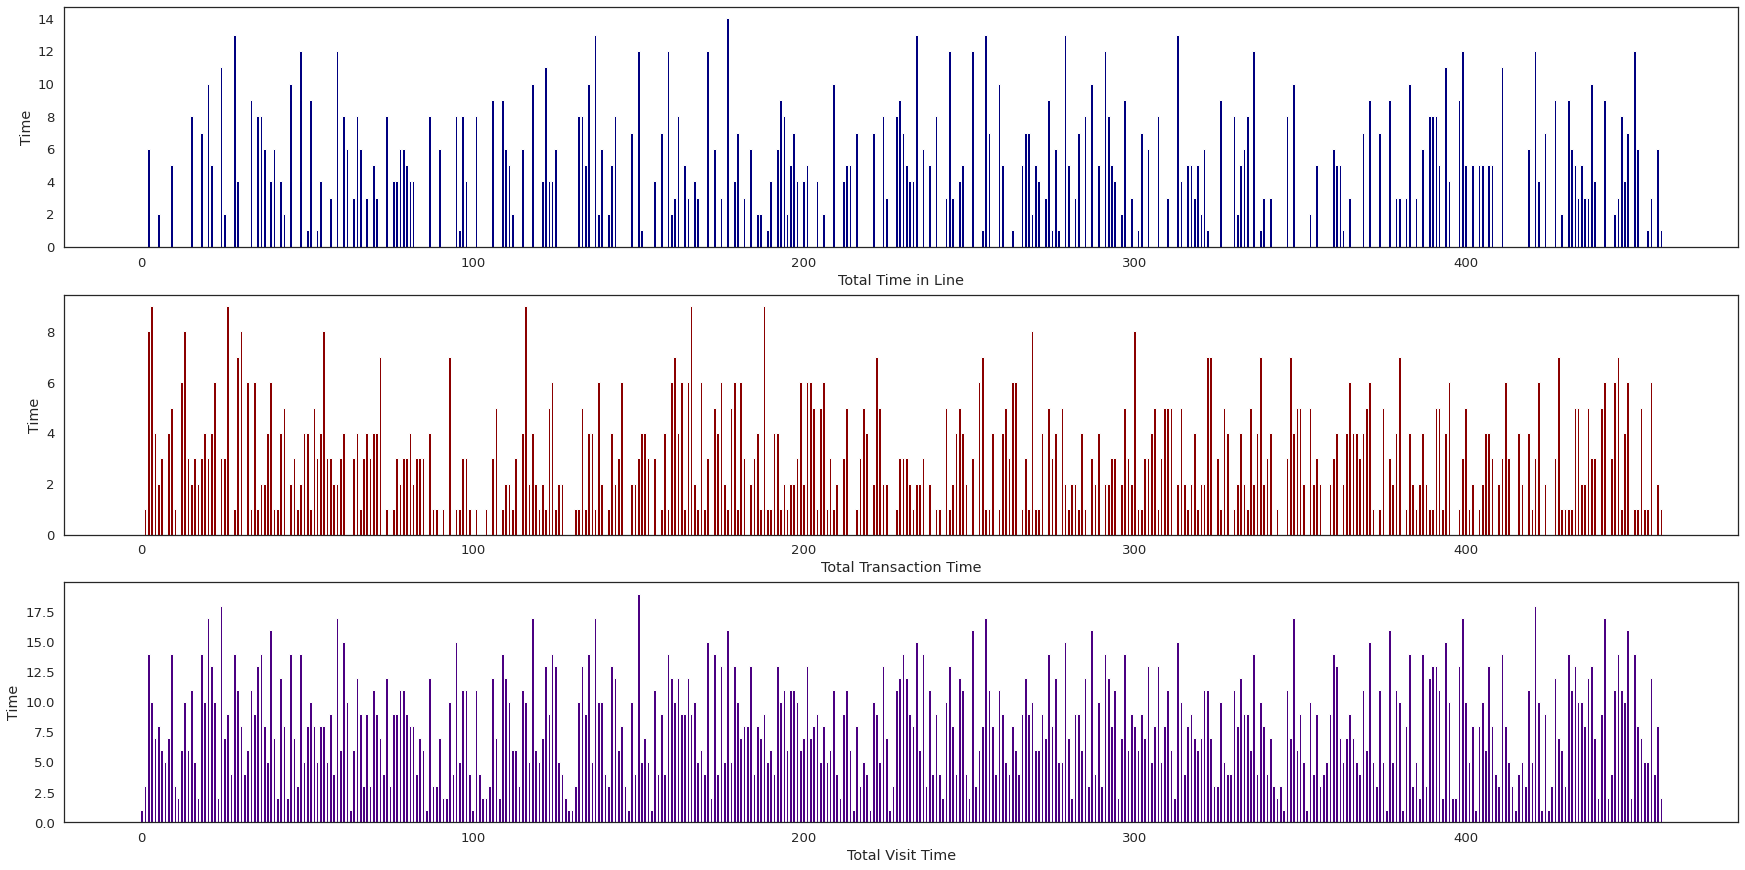

In [13]:
min_in_line, sec_in_line = calculate_time_in_line(time_in_line)
min_trans, sec_trans = calculate_transaction_time(transaction_time)
min, sec = calculate_wait_time(wait_times)

print("\nRunning simulation...\n",)

display(data_table.DataTable(record, include_index = False, num_rows_per_page=5))

print(
      f"\nThe average time spent waiting in line is {min_in_line} minutes and {sec_in_line} seconds.",
      f"\nThe average transaction time is {min_trans} minutes and {sec_trans} seconds.",
      f"\nThe average time spent at the bank is {min} minutes and {sec} seconds.\n",
  )


# Draw first subplot using plt.subplot (3 rows, 1 column, plot data for graph 1)
plt.subplot(3, 1, 1)
plt.bar(np.arange(len(record['Total Time in Line'])), record['Total Time in Line'], color='navy')
plt.xlabel('Total Time in Line')
plt.ylabel('Time')

# Draw second subplot using plt.subplot (3 rows, 1 column, plot data for graph 2)
plt.subplot(3, 1, 2)
plt.bar(np.arange(len(record['Total Transaction Time'])) , record['Total Transaction Time'], color='darkred')
plt.xlabel('Total Transaction Time')
plt.ylabel('Time')

# Draw third sublpot using plt.subplot (3 rows, 1 column, plot data for graph 3)
plt.subplot(3, 1, 3)
plt.bar(np.arange(len(record['Total Visit Time'])), record['Total Visit Time'], color = 'indigo')
plt.xlabel('Total Visit Time')
plt.ylabel('Time')

# Manipluates the size of the graphs
plt.gcf().set_size_inches(30, 15)

# Manipluates the size between each graph
subplots_adjust(hspace=.2)

# Displays plots
plt.show()

[**Slide Deck**](https://docs.google.com/presentation/d/1Bmvpi8jSve6e-MD2xjKpfrnfl5kMvloduunF6GjsG7w/edit?usp=sharing)

**References**  
https://realpython.com/simpy-simulating-with-python/  
https://pythonhosted.org/SimPy/Tutorials/TheBank.html   
https://careerkarma.com/blog/python-local-variable-referenced-before-assignment/  
https://colab.research.google.com/notebooks/data_table.ipynb#scrollTo=oEQUmjXkHZz-  
https://stackoverflow.com/questions/55861340/how-to-fix-attributeerror-unknown-property-figsize  
https://simpy.readthedocs.io/en/latest/topical_guides/porting_from_simpy2.html?highlight=yield#simpy-keywords-hold-etc  
https://shantoroy.com/python/python-bar-chart-using-matplotlib/